In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import seaborn as sns

In [ ]:
# Load the Parquet file
file_path = "/content/yellow_tripdata_2024-01.parquet"
df = pd.read_parquet(file_path)

# View the first few rows
print(df.head())

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2024-01-01 00:57:55   2024-01-01 01:17:43              1.0   
1         1  2024-01-01 00:03:00   2024-01-01 00:09:36              1.0   
2         1  2024-01-01 00:17:06   2024-01-01 00:35:01              1.0   
3         1  2024-01-01 00:36:38   2024-01-01 00:44:56              1.0   
4         1  2024-01-01 00:46:51   2024-01-01 00:52:57              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.72         1.0                  N           186            79   
1           1.80         1.0                  N           140           236   
2           4.70         1.0                  N           236            79   
3           1.40         1.0                  N            79           211   
4           0.80         1.0                  N           211           148   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


In [ ]:
# Check column names and data types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [ ]:
# Check for missing values
print(df.isnull().sum())

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          140162
trip_distance                 0
RatecodeID               140162
store_and_fwd_flag       140162
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     140162
Airport_fee              140162
dtype: int64


In [ ]:
# Statistical summary of numeric columns
print(df.describe())

           VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  2.964624e+06                     2964624                     2964624   
mean   1.754204e+00  2024-01-17 00:46:36.431092  2024-01-17 01:02:13.208130   
min    1.000000e+00         2002-12-31 22:59:39         2002-12-31 23:05:41   
25%    2.000000e+00  2024-01-09 15:59:19.750000         2024-01-09 16:16:23   
50%    2.000000e+00  2024-01-17 10:45:37.500000  2024-01-17 11:03:51.500000   
75%    2.000000e+00  2024-01-24 18:23:52.250000         2024-01-24 18:40:29   
max    6.000000e+00         2024-02-01 00:01:15         2024-02-02 13:56:52   
std    4.325902e-01                         NaN                         NaN   

       passenger_count  trip_distance    RatecodeID  PULocationID  \
count     2.824462e+06   2.964624e+06  2.824462e+06  2.964624e+06   
mean      1.339281e+00   3.652169e+00  2.069359e+00  1.660179e+02   
min       0.000000e+00   0.000000e+00  1.000000e+00  1.000000e+00   
25%       1.

In [ ]:
# Reduce dataset to 10% of its original size
df_reduced = df.sample(frac=0.5, random_state=42)  # Adjust random_state for reproducibility

print(f"Original dataset size: {len(df)}")
print(f"Reduced dataset size: {len(df_reduced)}")


Original dataset size: 2964624
Reduced dataset size: 1482312


In [ ]:
# Fill missing values for passenger_count with the median
df['passenger_count'].fillna(df['passenger_count'].median(), inplace=True)

# Fill missing values for RatecodeID with the mode (most frequent value)
df['RatecodeID'].fillna(df['RatecodeID'].mode()[0], inplace=True)

# Fill missing values for store_and_fwd_flag with 'N' (default for "not stored")
df['store_and_fwd_flag'].fillna('N', inplace=True)

# Fill missing values for congestion_surcharge and Airport_fee with 0
df['congestion_surcharge'].fillna(0, inplace=True)
df['Airport_fee'].fillna(0, inplace=True)

# Replace negative or invalid values in certain columns with 0
columns_to_fix = ['extra', 'mta_tax', 'tolls_amount', 'congestion_surcharge', 'Airport_fee']
for col in columns_to_fix:
    df[col] = df[col].apply(lambda x: max(x, 0))  # Replace negative values with 0

# Confirm there are no missing values left
print(df.isnull().sum())

<ipython-input-7-fd6e1030ec65>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['passenger_count'].fillna(df['passenger_count'].median(), inplace=True)
<ipython-input-7-fd6e1030ec65>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
Airport_fee              0
dtype: int64


# New Section

Data after removing outliers: 2645823 rows


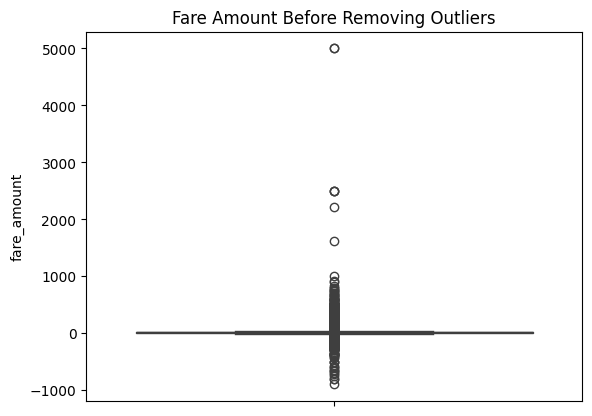

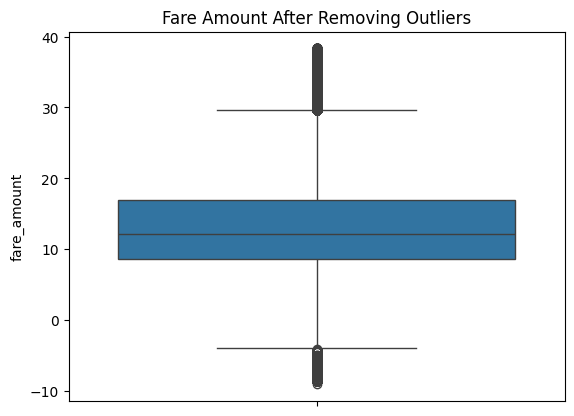

In [ ]:
#identify numerical and categorical features
numerical_features = df.select_dtypes(include=np.number).columns
categorical_features = df.select_dtypes(exclude=np.number).columns

# Remove outliers based on the IQR method for 'fare_amount'
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df_filtered = df[(df['fare_amount'] >= lower_bound) & (df['fare_amount'] <= upper_bound)]

# Check how much data was removed
print(f"Data after removing outliers: {df_filtered.shape[0]} rows")

# Visualize the fare_amount before and after removing outliers
sns.boxplot(df['fare_amount'])
plt.title('Fare Amount Before Removing Outliers')
plt.show()

sns.boxplot(df_filtered['fare_amount'])
plt.title('Fare Amount After Removing Outliers')
plt.show()

In [ ]:
# Feature Engineering: Extract useful features from datetime columns
df_filtered['pickup_datetime'] = pd.to_datetime(df_filtered['tpep_pickup_datetime'])
df_filtered['dropoff_datetime'] = pd.to_datetime(df_filtered['tpep_dropoff_datetime'])

# Extract date-time features
df_filtered['hour_of_day'] = df_filtered['pickup_datetime'].dt.hour
df_filtered['minute'] = df_filtered['pickup_datetime'].dt.minute
df_filtered['day_of_week'] = df_filtered['pickup_datetime'].dt.dayofweek
df_filtered['month'] = df_filtered['pickup_datetime'].dt.month

<ipython-input-9-ab613ee54e2a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pickup_datetime'] = pd.to_datetime(df_filtered['tpep_pickup_datetime'])
<ipython-input-9-ab613ee54e2a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['dropoff_datetime'] = pd.to_datetime(df_filtered['tpep_dropoff_datetime'])
<ipython-input-9-ab613ee54e2a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [ ]:
# Select relevant features for prediction
features = ['trip_distance', 'hour_of_day', 'minute', 'day_of_week', 'month', 'passenger_count']
target = 'fare_amount'

# Prepare the data
X = df_filtered[features]
y = df_filtered[target]

# Normalize the features using MinMaxScaler
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

X_scaled = scaler_features.fit_transform(X)
y_scaled = scaler_target.fit_transform(y.values.reshape(-1, 1))

# Reshape data for LSTM input (samples, time steps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [ ]:
# Build the RNN model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_scaled.shape[1], X_scaled.shape[2])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_scaled, y_scaled, epochs=20, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
66146/66146 ━━━━━━━━━━━━━━━━━━━━ 205s 3ms/step - loss: 0.0242 - val_loss: 0.0272
Epoch 2/20
66146/66146 ━━━━━━━━━━━━━━━━━━━━ 209s 3ms/step - loss: 0.0235 - val_loss: 0.0276
Epoch 3/20
66146/66146 ━━━━━━━━━━━━━━━━━━━━ 205s 3ms/step - loss: 0.0235 - val_loss: 0.0295
Epoch 4/20
66146/66146 ━━━━━━━━━━━━━━━━━━━━ 261s 3ms/step - loss: 0.0234 - val_loss: 0.0338
Epoch 5/20
66146/66146 ━━━━━━━━━━━━━━━━━━━━ 191s 3ms/step - loss: 0.0235 - val_loss: 0.0421
Epoch 6/20
66146/66146 ━━━━━━━━━━━━━━━━━━━━ 189s 3ms/step - loss: 0.0234 - val_loss: 2.6133
Epoch 7/20
66146/66146 ━━━━━━━━━━━━━━━━━━━━ 217s 3ms/step - loss: 0.0627 - val_loss: 863.1406
Epoch 8/20
66146/66146 ━━━━━━━━━━━━━━━━━━━━ 262s 3ms/step - loss: 0.3329 - val_loss: 775.8480
Epoch 9/20
66146/66146 ━━━━━━━━━━━━━━━━━━━━ 246s 3ms/step - loss: 0.7689 - val_loss: 706.5260
Epoch 10/20
66146/66146 ━━━━━━━━━━━━━━━━━━━━ 204s 3ms/step - loss: 0.0244 - val_loss: 631.3192
Epoch 11/20
66146/66146 ━━━━━━━━━━━━━━━━━━━━ 245s 3ms/step - loss: 0.19

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save the model_
model.save('/content/drive/MyDrive/taxi_fare_prediction_model.keras')

# Save the preprocessed dataset
df_filtered.to_csv('/content/drive/MyDrive/taxi_fare_prediction_data.csv', index=False)

# Save the scalers
import joblib
joblib.dump(scaler_features, '/content/drive/MyDrive/tax_scaler_features.pkl')
joblib.dump(scaler_target, '/content/drive/MyDrive/tax_scaler_target.pkl')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/tax_scaler_target.pkl']

In [ ]:
# prompt: predict on test data and plot actual and predicted

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
from tensorflow.keras.models import load_model

# Load the saved model and scalers
model = load_model('/content/drive/MyDrive/taxi_fare_prediction_model.keras')
scaler_features = joblib.load('/content/drive/MyDrive/tax_scaler_features.pkl')
scaler_target = joblib.load('/content/drive/MyDrive/tax_scaler_target.pkl')

# Load the test data (replace with your actual test data path)
test_data_path = '/content/drive/MyDrive/taxi_fare_prediction_data.csv'
test_df = pd.read_csv(test_data_path)


# Select relevant features for prediction
features = ['trip_distance', 'hour_of_day', 'minute', 'day_of_week', 'month', 'passenger_count']
target = 'fare_amount'


# Prepare the test data
X_test = test_df[features]
y_test = test_df[target]

# Scale the test features
X_test_scaled = scaler_features.transform(X_test)

# Reshape for LSTM input
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Make predictions
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform the predictions to get actual fare amounts
y_pred = scaler_target.inverse_transform(y_pred_scaled)

# Plot actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual')  # Limit to 100 points for better visibility
plt.plot(y_pred[:100], label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Fare Amount')
plt.title('Actual vs. Predicted Fare Amounts')
plt.legend()

plt.show()


 8279/82682 ━━━━━━━━━━━━━━━━━━━━ 2:07 2ms/step

In [ ]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.1 MB/s eta 0:00:00


In [ ]:
def calculate_next_slots(h, m):
  slots = []
  slots.append((h,m))
  current_minutes = h * 60 + m

  for _ in range(3):
    current_minutes += 15
    new_h = current_minutes // 60
    new_m = current_minutes % 60
    slots.append((new_h, new_m))

  return slots

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import joblib

# Load the saved model and scalers
model = load_model('/content/drive/MyDrive/taxi_fare_prediction_model.keras')
scaler_features = joblib.load('/content/drive/MyDrive/tax_scaler_features.pkl')
scaler_target = joblib.load('/content/drive/MyDrive/tax_scaler_target.pkl')



def predict_fare(trip_distance, hour_of_day, minute, day_of_week, month, passenger_count):
    if passenger_count > 4 or passenger_count < 1:
        return 'Invalid Passenger count', '', '', ''

    next_slots = calculate_next_slots(hour_of_day, minute)
    predictions = []
    for i in range(4):
        row = np.array([[trip_distance, next_slots[i][0], next_slots[i][1], day_of_week, month, passenger_count]])
        input_scaled = scaler_features.transform(row)
        input_scaled = input_scaled.reshape((input_scaled.shape[0], 1, input_scaled.shape[1]))
        prediction = model.predict(input_scaled)
        fare = round(prediction[0][0] * 86)
        predictions.append(f"{next_slots[i][0]}:{next_slots[i][1]} - {fare} rupees")

    return predictions[0], predictions[1], predictions[2], predictions[3]

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_fare,
    inputs=[
        gr.Number(label="Trip Distance"),
        gr.Number(label="Hour of Day (0-23)"),
        gr.Number(label="Minute (0-59)"),
        gr.Number(label="Day of Week (1-7, 1=Monday)"),
        gr.Number(label="Month (1-12)"),
        gr.Number(label="Passenger Count (1-4)")
    ],
    outputs=[
        gr.Textbox(label="Fare at Slot 1"),
        gr.Textbox(label="Fare at Slot 2"),
        gr.Textbox(label="Fare at Slot 3"),
        gr.Textbox(label="Fare at Slot 4")
    ],
    title="Taxi Fare Prediction",
    description="Predict the fare amount for a taxi trip in New York City.",allow_flagging='never'
)

# Launch the interface
iface.launch(debug=True)


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4b445ef0677e0a5a7f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
